In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import utilities as u


df_seattle = pd.read_csv('./SEATTLE/listings.csv')
df_boston = pd.read_csv('./BOSTON/listings.csv')


In [2]:
#removing text columns from the dataframes
df_boston_clean = df_boston.drop(['id','listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','transit', 
                'neighborhood_overview','notes','access','thumbnail_url','host_url','medium_url',
                'picture_url', 'house_rules','interaction','xl_picture_url','host_id','host_name','host_location',
                'host_about','host_thumbnail_url','host_picture_url', 'street','state','zipcode', 'market',
                 'smart_location','country_code','country','license', 'jurisdiction_names','calendar_last_scraped'], axis=1)

df_seattle_clean = df_seattle.drop(['id','listing_url','scrape_id','last_scraped','name',
                'summary','space','description','experiences_offered','transit', 
         'neighborhood_overview','notes','thumbnail_url','host_url','medium_url',
        'picture_url','xl_picture_url','host_id','host_name','host_location',
        'host_about','host_thumbnail_url','host_picture_url', 'street','state','zipcode', 'market',
         'smart_location','country_code','country','license', 'jurisdiction_names','calendar_last_scraped'], axis=1)

In [3]:
#concatenate two dataframes into one single
df = pd.concat([df_boston_clean,df_seattle_clean],axis=0, ignore_index=True)


In [4]:
#convert all amount columns into float
df_new = u.convert_amount(df.copy(), ['security_deposit','price','monthly_price','cleaning_fee','weekly_price', 'extra_people'])

In [5]:
#separating amentities and host_verifications into separate coulumns
df_final, amenities_list = u.seperate_col('amenities',df_new.copy(),',')
df_final, host_verfications_list = u.seperate_col('host_verifications',df_final.copy(), ',')

/home/piyush/UDACITY/DATASCIENCENANODEGREEPROGRAM/Projects/AIRBNB/utilities.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['No_of_'+col][i] = len(columns)
/home/piyush/UDACITY/DATASCIENCENANODEGREEPROGRAM/Projects/AIRBNB/utilities.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = True
/home/piyush/UDACITY/DATASCIENCENANODEGREEPROGRAM/Projects/AIRBNB/utilities.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [6]:
#change host_since into no of days the person has hosted the listing by taking a reference date.
import time
ref_date = pd.to_datetime(time.strftime('%Y-%m-%d'))
df_final['host_since'] =df_final['host_since'].apply(pd.to_datetime)
df_final['host_since']=(ref_date-df_final['host_since'])
df_final['host_since'] = df_final['host_since']/np.timedelta64(1,'D')
df_final['reviewed_days'] = (df_final['last_review'].apply(pd.to_datetime)-df_final['first_review'].apply(pd.to_datetime))/np.timedelta64(1,'D')

In [7]:
df_final['reviewed_days']

0          NaN
1        804.0
2       2574.0
3          0.0
4        380.0
         ...  
7398       0.0
7399       6.0
7400       NaN
7401       NaN
7402       NaN
Name: reviewed_days, Length: 7403, dtype: float64

In [8]:
#dropping other irrelevant columns
df_final = df_final.drop(['neighbourhood_group_cleansed','neighbourhood_cleansed','square_feet'
                  ,'has_availability','last_review','first_review','calendar_updated','host_neighbourhood','neighbourhood','city'],axis=1)
    
#convert percentage columns to float
df_final[['host_response_rate','host_acceptance_rate']] = df_final[['host_response_rate','host_acceptance_rate']].replace('[\%,]', '', regex=True).astype(float)

In [9]:
#numerical and categorical columns
num_cols = df_final.select_dtypes(include=['int64','float64']).copy().columns
cat_cols = df_final.select_dtypes(include='object').copy().columns

In [10]:
#finding correlation between columns
#cor = df_final[list(num_cols)+amenities_list+host_verfications_list].corr()
cor = df_final[num_cols].corr()

#finding correlation of price column with other columns and ignoring those columns based on certain value.
cor_target = cor["price"]
relevant_features = cor_target[cor_target>0.1]

<AxesSubplot:>

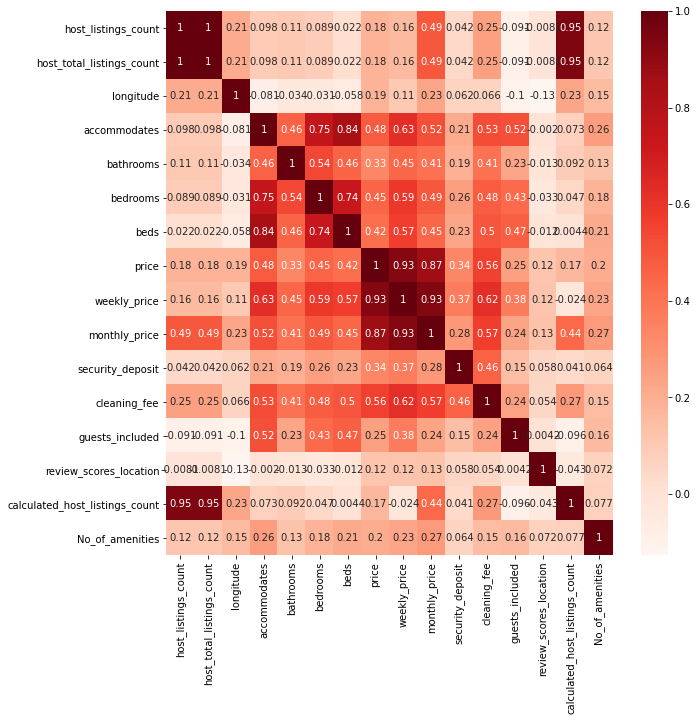

In [11]:
selected_numeric_columns = list(relevant_features.to_dict().keys())
cor = df_final[selected_numeric_columns].corr()

#plotting heatmap again to see correlations.
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,ax=ax)

In [12]:
selected_numeric_columns

['host_listings_count',
 'host_total_listings_count',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'review_scores_location',
 'calculated_host_listings_count',
 'No_of_amenities']

In [13]:
'''from the above heatmap we see host_listing_count, host_total_listings_count, 
calculated_host_listings_count are highly correlated and hence we wound just keep only one of those'''

for x in ['calculated_host_listings_count','host_total_listings_count']:
    selected_numeric_columns.remove(x)


In [15]:
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = u.clean_data_model(u.fill_nan_data(df_final[selected_numeric_columns],False),'price',0.3,42)

/usr/lib/python3/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [16]:
#the following train and test scores are based on only numerical columns
print(test_score)
print(train_score)

0.542305547409607
0.35482987126000576


In [18]:
'''Now we'll use a different approach known as Backward elimination to extract numeric columns for our model
Reference : https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b '''

#using Backward Elimination
df_temp = u.fill_nan_data(df_final,False)
X=df_temp[num_cols].drop(['price'],axis=1)
y=df_temp['price']
cols = list(X.columns)
pmax = 1
while(len(cols)>0):
    p=[]
    df_1 = X[cols]
    df_1 = sm.add_constant(df_1)
    model = sm.OLS(y.astype(float),df_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_numeric_features2 = cols

In [19]:
selected_numeric_features2

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'No_of_amenities',
 'No_of_host_verifications']

Best alpha using built-in LassoCV: 338.918693
Best score using built-in LassoCV: 0.298304


Text(0.5, 1.0, 'Feature importance using Lasso Model')

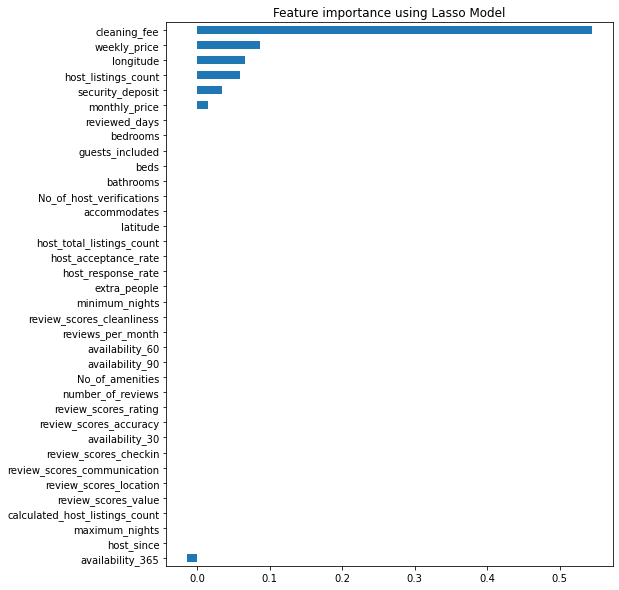

In [20]:
#Lasso Regularization for Feature selection
import matplotlib
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [21]:
'''for extracting categorical features using hot label encoder and P Value
Reference: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf'''

data = df_final[cat_cols]
label_encoder = LabelEncoder()

for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col]).astype('float64')

<ipython-input-21-f6160ae4dc66>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = label_encoder.fit_transform(data[col]).astype('float64')


<AxesSubplot:>

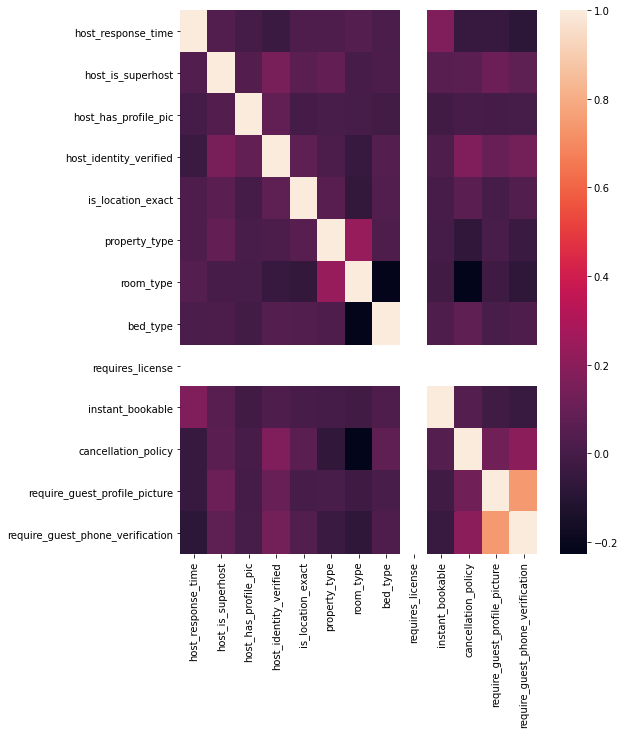

In [22]:
corr=data.corr()
sns.heatmap(corr)

In [23]:
#selecting columns based on Pvalue
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [24]:
#final list of columns (categorical)
sel_cat_col = data.columns[columns]

In [25]:
sel_cat_col

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'property_type',
       'room_type', 'bed_type', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [30]:
#train model
data = df_final
label_encoder = LabelEncoder()

for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col]).astype('float64')
    
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = u.clean_data_model(u.fill_nan_data(data[list(selected_numeric_features2)+['price']+list(sel_cat_col)],False),'price',0.3,42)

/usr/lib/python3/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [31]:
#train and test scores
print(test_score)
print(train_score)

0.5741539578074953
0.38816859806463855
